<a href="https://colab.research.google.com/github/Song-Jun-Ho/RNN_Attention_Transformer/blob/main/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
Change directory to where this file is located
"""
%cd '/content/drive/MyDrive/HW4'

/content/drive/MyDrive/HW4


In [ ]:
! pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset

In [ ]:
"""
import modules you need
"""


'\nimport modules you need\n'

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE)) ## should be 1.11.0 and cuda
print("Using torchtext version: {}".format(torchtext.__version__)) ## should be 0.12.0

Using PyTorch version: 1.11.0+cu113, Device: cuda
Using torchtext version: 0.12.0


# Load Data

In [ ]:
"""
Load AG_NEWS dataset and set up the tokenizer and encoder pipeline.

Do NOT modify.
"""

train_data, test_data = torchtext.datasets.AG_NEWS(root='./data')

tokenizer = get_tokenizer('basic_english')

def tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

encoder = build_vocab_from_iterator(tokens(train_data), specials=["<unk>"])
encoder.set_default_index(encoder["<unk>"])
# print(len(encoder))

text_pipeline = lambda x: encoder(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [ ]:
def collate_batch(batch):
    """
    Creates a batch of encoded text, label and token length tensors.

    Inputs
    - list of tuples, each containing an integer label and a text input
    - number of tuples in the list == BATCH SIZE
    Returns
    - text_list: batch of encoded long type text tensors with size (TOKEN_LENGTH, BATCH)
    - label_list: batch of label tensors with size (BATCH)
    - len_list: batch of token length tensors with size (BATCH)
    """

    text_list, label_list, len_list = [], [], []
    
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        len_list.append(processed_text.size(0))
        text_list.append(processed_text)

    label_list = torch.tensor(label_list, dtype=torch.int64)
    len_list = torch.tensor(len_list, dtype=torch.int64)
    #print(len_list)
    mx_len = int(torch.mean(len_list.float()).item())

    for i, _processed_text in enumerate(text_list):
        if _processed_text.size(0) >= mx_len:
            text_list[i] = _processed_text[:mx_len]
            len_list[i] = mx_len
        else:
            text_list[i] = torch.cat([_processed_text, torch.zeros(mx_len - _processed_text.size(0))])
    
    text_list = torch.stack(text_list).long()
    text_list = torch.permute(text_list, (1, 0))  # (TOKEN_LENGTH, BATCH)
    
    assert text_list.size(1) == len(batch)

    return text_list, label_list, len_list

In [ ]:
"""
Load the data loader.

Do NOT modify.
"""

BATCH_SIZE = 512

train_dataset = to_map_style_dataset(train_data)
test_dataset = to_map_style_dataset(test_data)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)

In [ ]:
"""
Print out the first batch in the train loader.
Check if the collate function is implemented correctly.

Do NOT modify.
"""

for batch_x, batch_y, len_x in train_dataloader:
    print(batch_x[:10])
    print(batch_y[:10])
    print(len_x[:10])
    print(batch_x.shape)
    print(batch_y.shape)
    print(len_x.shape)
    break

tensor([[  886,  2374,   178,  ...,   151,  3359,  5657],
        [    3,  4072,   730,  ...,   338,   428, 50047],
        [17440,  2781, 10327,  ...,    10,    95, 11237],
        ...,
        [   10,    28,   730,  ...,    23,  2970,   717],
        [  989, 15070, 10327,  ...,    73,  3426,  5657],
        [  107,    48,  8856,  ...,    15,   281, 50047]])
tensor([3, 3, 3, 2, 3, 2, 2, 1, 1, 1])
tensor([43, 39, 43, 37, 23, 43, 42, 43, 43, 34])
torch.Size([43, 512])
torch.Size([512])
torch.Size([512])


(array([  4.,   0.,   0.,  74.,   0.,   0., 130.,   0.,   0.,  27.]),
 array([41. , 41.3, 41.6, 41.9, 42.2, 42.5, 42.8, 43.1, 43.4, 43.7, 44. ]),
 <a list of 10 Patch objects>)

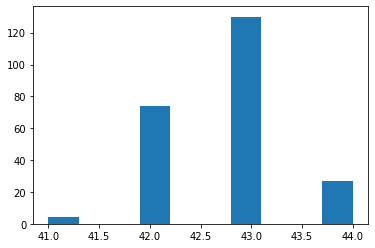

In [ ]:
"""
Plot the sequence length distribution of the batches in the train dataloader.
Make sure that all batches have difference sequence lengths.

Do NOT modify.
"""

batch_len = []
for batch_x, _, _ in train_dataloader:
    batch_len.append(batch_x.size(0))
plt.hist(batch_len)

# Model

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, num_class):
        """
        Define the model weight parameters and initialize the weights.

        """
        super(RNN, self).__init__()

        whh_size = (hidden_size, hidden_size)
        wxh_size = (input_size, hidden_size)
        why_size = (hidden_size, num_class)
        bhh_size = hidden_size
        bxh_size = hidden_size
        bhy_size = num_class

        kwargs = {'device': DEVICE, 'dtype': torch.float}
        self.hidden = hidden_size
        self.num_class = num_class
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.W_hh = nn.parameter.Parameter(torch.empty(whh_size, **kwargs))
        self.W_xh = nn.parameter.Parameter(torch.empty(wxh_size, **kwargs))
        self.W_hy = nn.parameter.Parameter(torch.empty(why_size, **kwargs))
        self.b_hh = nn.parameter.Parameter(torch.empty(bhh_size, **kwargs))
        self.b_xh = nn.parameter.Parameter(torch.empty(bxh_size, **kwargs))
        self.b_hy = nn.parameter.Parameter(torch.empty(bhy_size, **kwargs))

        self.init_parameters()

    def init_parameters(self):
        """
        Initialize the parameters with Kaiming uniform initialization.

        Do NOT modify this method.
        """
        nn.init.kaiming_uniform_(self.W_hh, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_hh)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.b_hh, -bound, bound)
        nn.init.kaiming_uniform_(self.W_xh, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_xh)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.b_xh, -bound, bound)
        nn.init.kaiming_uniform_(self.W_hy, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_hy)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.b_hy, -bound, bound)

    def forward(self, inputs, length):
        """
        Inputs
        - a batch of encoded token sequences with shape (SEQ_LEN, BATCH_SIZE)
        - a batch of token lengths with shape (BATCH_SIZE)
        Returns
        - Softmax probabilites for each class with shape (BATCH_SIZE, NUM_CLASS)
        """
        
        rnn_outputs = []  # (SEQ_LEN, BATCH_SIZE, NUM_CLASS)
        hiddens_for_y = None  # (BATCH_SIZE, NUM_CLASS)
        embed_inputs = self.embedding(inputs)  # inputs : (SEQ_LEN, BATCH_SIZE) -> embed_inputs : (SEQ_LEN, BATCH_SIZE, input_size)

        h_0 = torch.zeros(inputs.size(1), self.hidden).to(DEVICE) # (BATCH_SIZE, HIDDEN_DIM)
        h = h_0
        for t in range(inputs.size(0)):
            temp1 = torch.matmul(embed_inputs[t], self.W_xh) + self.b_xh  # (BATCH_SIZE, HIDDEN_DIM)
            temp2 = torch.matmul(h, self.W_hh) + self.b_hh # (BATCH_SIZE, HIDDEN_DIM)
            h = F.tanh(temp1 + temp2)
            output = torch.matmul(h, self.W_hy) + self.b_hy   # (BATCH_SIZE, NUM_CLASS)
            rnn_outputs.append(output)

        rnn_outputs = torch.stack(rnn_outputs).to(DEVICE)  # (SEQ_LEN, BATCH_SIZE, NUM_CLASS)
        rnn_y = rnn_outputs[length - 1, np.arange(inputs.size(1))].to(DEVICE)  # (BATCH_SIZE, NUM_CLASS)

        softmax_probs = F.softmax(rnn_y, dim=1)

        return softmax_probs
    
    def compute_loss(self, prediction, label):
        """
        Inputs
        - prediction: output from self.forward(inputs) with shape (BATCH_SIZE, NUM_CLASS)
        - label: integer labels of the batch inputs with shape (BATCH_SIZE)
        Returns
        - cross entropy loss of the batch (float) and number of correct predictions (integer)
        """
        loss = 0
        correct = 0

        batch_size = prediction.size(0)
        loss = -torch.sum(torch.log(prediction[np.arange(batch_size), label] + 1e-7))
        correct = (prediction.argmax(1) == label).sum().item()

        return loss, correct

# Training Modules

In [ ]:
class ScheduledOptim():
    """
    Learning rate scheduler.

    Do NOT modify.
    """

    def __init__(self, optimizer, n_warmup_steps, decay_rate):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.decay = decay_rate
        self.n_steps = 0
        self.initial_lr = optimizer.param_groups[0]['lr']
        self.current_lr = optimizer.param_groups[0]['lr']

    def zero_grad(self):
        self._optimizer.zero_grad()
    
    def step(self):
        self._optimizer.step()
    
    def get_lr(self):
        return self.current_lr
    
    def update(self):
        if self.n_steps < self.n_warmup_steps:
            lr = self.n_steps / self.n_warmup_steps * self.initial_lr
        elif self.n_steps == self.n_warmup_steps:
            lr = self.initial_lr
        else:
            lr = self.current_lr * self.decay
        
        self.current_lr = lr
        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

        self.n_steps += 1

In [ ]:
"""
Functions for training and evaluating the model.

"""

def train(model, train_loader, scheduler):
    model.train()
    train_loss = 0
    correct = 0
  
    tqdm_bar = tqdm(train_loader)

    for text, label, length in tqdm_bar:
        text = text.to(DEVICE)
        label = label.to(DEVICE)
        length = length.to(DEVICE)

        scheduler.zero_grad()
        
        prediction = model(text, length)
        loss, _correct = model.compute_loss(prediction, label)
        train_loss += loss
        correct += _correct

        loss.backward()
        scheduler.step()

    scheduler.update()

    train_loss /= len(train_loader.dataset)
    train_acc = 100. * correct / len(train_loader.dataset)
    
    return train_loss, train_acc

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    total_count = 0
    with torch.no_grad():
        for text, label, length in test_loader:
            text = text.to(DEVICE)
            label = label.to(DEVICE)
            length = length.to(DEVICE)

            prediction = model(text, length)
            loss, _correct = model.compute_loss(prediction, label)
            test_loss += test_loss
            correct += _correct
            total_count += label.size(0)
            
    test_acc = 100. * correct / total_count

    return test_loss, test_acc

# Model Training

In [ ]:
EPOCHS = 30
vocab_size = len(encoder)
input_size = 128
hidden_size = 128
num_class = len(set([label for (label, text) in train_data]))

model = RNN(vocab_size, input_size, hidden_size, num_class).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ScheduledOptim(optimizer, n_warmup_steps=10, decay_rate=0.95)

scheduler.update()

for epoch in range(1, EPOCHS + 1):
    loss_train, accu_train = train(model, train_dataloader, scheduler)
    loss_val, accu_val = evaluate(model, valid_dataloader)
    lr = scheduler.get_lr()
    print('-' * 83)
    print('| end of epoch {:2d} | lr: {:5.4f} | train accuracy: {:8.3f} | '
          'valid accuracy {:8.3f} '.format(epoch, lr, accu_train, accu_val))
    print('-' * 83)

  0%|          | 0/235 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


-----------------------------------------------------------------------------------
| end of epoch  1 | lr: 0.0001 | train accuracy:   24.334 | valid accuracy   24.263 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  2 | lr: 0.0002 | train accuracy:   28.512 | valid accuracy   31.237 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  3 | lr: 0.0003 | train accuracy:   34.293 | valid accuracy   37.868 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  4 | lr: 0.0004 | train accuracy:   50.769 | valid accuracy   57.987 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  5 | lr: 0.0005 | train accuracy:   70.339 | valid accuracy   77.342 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  6 | lr: 0.0006 | train accuracy:   82.293 | valid accuracy   82.566 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  7 | lr: 0.0007 | train accuracy:   86.399 | valid accuracy   84.632 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  8 | lr: 0.0008 | train accuracy:   88.539 | valid accuracy   86.329 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  9 | lr: 0.0009 | train accuracy:   90.269 | valid accuracy   85.316 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 10 | lr: 0.0010 | train accuracy:   91.459 | valid accuracy   87.118 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 11 | lr: 0.0009 | train accuracy:   92.433 | valid accuracy   88.079 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 12 | lr: 0.0009 | train accuracy:   93.784 | valid accuracy   88.276 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 13 | lr: 0.0009 | train accuracy:   94.624 | valid accuracy   88.342 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 14 | lr: 0.0008 | train accuracy:   95.302 | valid accuracy   88.092 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 15 | lr: 0.0008 | train accuracy:   96.110 | valid accuracy   86.566 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 16 | lr: 0.0007 | train accuracy:   96.373 | valid accuracy   88.750 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 17 | lr: 0.0007 | train accuracy:   97.006 | valid accuracy   88.592 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 18 | lr: 0.0007 | train accuracy:   97.391 | valid accuracy   88.145 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 19 | lr: 0.0006 | train accuracy:   97.537 | valid accuracy   88.355 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 20 | lr: 0.0006 | train accuracy:   97.979 | valid accuracy   89.145 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 21 | lr: 0.0006 | train accuracy:   98.057 | valid accuracy   88.105 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 22 | lr: 0.0005 | train accuracy:   98.347 | valid accuracy   88.500 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 23 | lr: 0.0005 | train accuracy:   98.558 | valid accuracy   88.303 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 24 | lr: 0.0005 | train accuracy:   98.515 | valid accuracy   88.079 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 25 | lr: 0.0005 | train accuracy:   98.802 | valid accuracy   88.355 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 26 | lr: 0.0004 | train accuracy:   98.953 | valid accuracy   88.303 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 27 | lr: 0.0004 | train accuracy:   99.095 | valid accuracy   87.342 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 28 | lr: 0.0004 | train accuracy:   99.155 | valid accuracy   88.382 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 29 | lr: 0.0004 | train accuracy:   99.158 | valid accuracy   88.421 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 30 | lr: 0.0004 | train accuracy:   99.329 | valid accuracy   88.382 
-----------------------------------------------------------------------------------
